In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)


n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)


mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)


S0, mu, sigma, dt = 25, 0.15, 0.3, 1/252
price = [S0]
for _ in range(1, n):
    shock = np.random.normal((mu - 0.5*sigma**2)*dt, sigma*np.sqrt(dt))
    price.append(price[-1] * np.exp(shock))
price = np.array(price)


asset_excess = np.diff(price) / price[:-1]  # first n-1 values
asset_excess = np.insert(asset_excess, 0, 0)  # align length with n


beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5


noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)

asset_excess_model = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + 
    beta_mom*momentum + beta_mom2*(momentum**2) + eps
)


df_factors = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess_model,
    'close': price
})

df_factors.head()


,date,mkt_excess,size,value,momentum,asset_excess,close
0,2024-02-01,0.005464,0.002862,-0.014350,0.004542,0.013116,25.000000
1,2024-02-02,-0.001521,0.004486,-0.005394,-0.005533,0.004794,25.457856
2,2024-02-05,0.007125,0.008664,0.000047,0.005218,0.017123,25.221296
3,2024-02-06,0.016753,0.008430,0.000423,0.008134,0.021009,25.277683
4,2024-02-07,-0.002576,-0.011021,-0.004051,0.002481,-0.006574,25.068257


In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats


df = df_factors.copy()
df.head()


,date,mkt_excess,size,value,momentum,asset_excess,close
0,2024-02-01,0.005464,0.002862,-0.014350,0.004542,0.013116,25.000000
1,2024-02-02,-0.001521,0.004486,-0.005394,-0.005533,0.004794,25.457856
2,2024-02-05,0.007125,0.008664,0.000047,0.005218,0.017123,25.221296
3,2024-02-06,0.016753,0.008430,0.000423,0.008134,0.021009,25.277683
4,2024-02-07,-0.002576,-0.011021,-0.004051,0.002481,-0.006574,25.068257


In [3]:

features = ['mkt_excess', 'size', 'value', 'momentum']
target = 'asset_excess'

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)


In [4]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Residuals
residuals = y_test - y_pred

In [5]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.6f}")

R²: 0.4048
RMSE: 0.009424


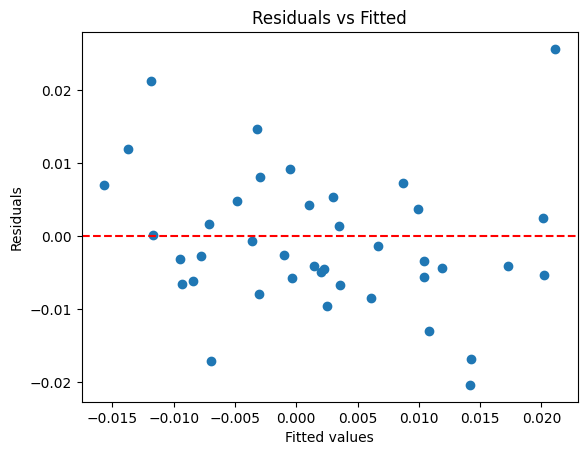

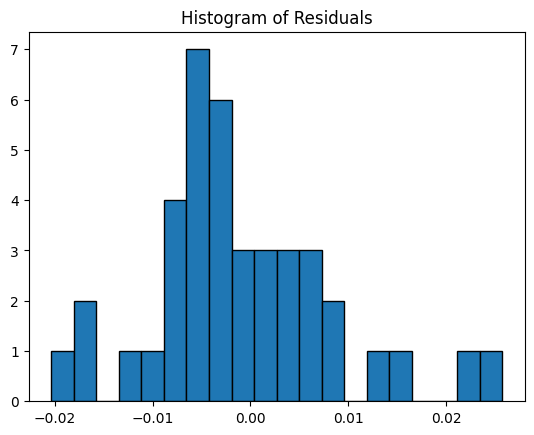

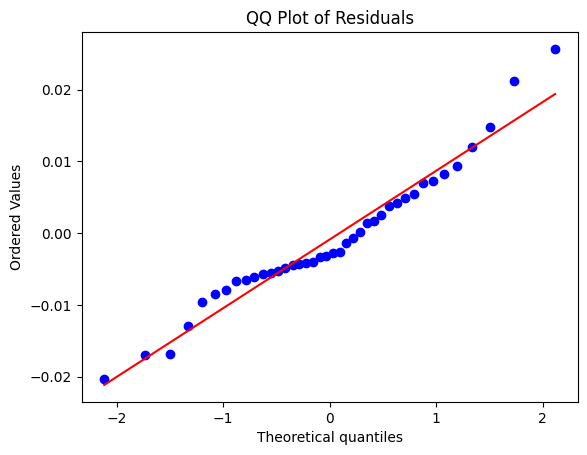

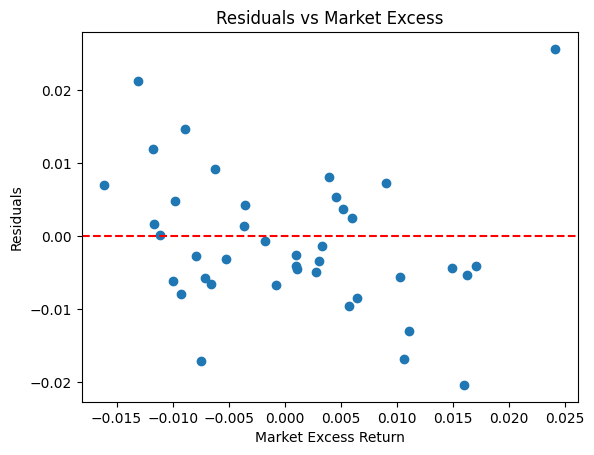

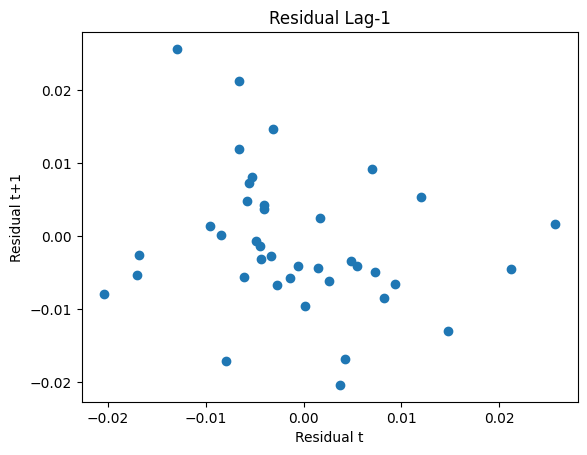

In [8]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Histogram of Residuals")
plt.show()


stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()


plt.scatter(X_test['mkt_excess'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Market Excess Return")
plt.ylabel("Residuals")
plt.title("Residuals vs Market Excess")
plt.show()


plt.scatter(residuals[:-1], residuals[1:])
plt.xlabel("Residual t")
plt.ylabel("Residual t+1")
plt.title("Residual Lag-1")
plt.show()

In [7]:
X_train['momentum_sq'] = X_train['momentum']**2
X_test['momentum_sq'] = X_test['momentum']**2

lr2 = LinearRegression()
lr2.fit(X_train, y_train)
y_pred2 = lr2.predict(X_test)
residuals2 = y_test - y_pred2

r2_2 = r2_score(y_test, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))

print(f"R² with squared momentum: {r2_2:.4f}")
print(f"RMSE with squared momentum: {rmse_2:.6f}")

R² with squared momentum: 0.4106
RMSE with squared momentum: 0.009378


# Linear Regression Markdown Interpretation

## Residual Analysis
- **Linearity:** Residuals vs fitted values should show no systematic pattern. Curvature suggests nonlinearity.
- **Homoscedasticity:** Residual variance should be constant across fitted values. Fanning or funnel shapes indicate heteroscedasticity.
- **Normality:** Histogram and QQ plot should approximate a normal distribution. Deviations suggest non-normal errors.
- **Independence:** Residual lag-1 plot should show no autocorrelation; random scatter supports independence.

## Optional Transformation
- Adding `momentum_sq` captures nonlinear effects while remaining linear in coefficients.
- Slight improvement in R² or RMSE can justify keeping this feature.

## Model Trust Assessment
- Evaluate R² and RMSE to see how well factors explain synthetic asset excess returns.
- Residual diagnostics indicate whether linear regression assumptions hold.
- If residuals appear roughly random, homoscedastic, and normal, model is reliable for prototyping or exploratory analysis.
